In [25]:
import os
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
# from dataset import AIAIRISDataset

**DataLoader**

In [42]:
import torch
import numpy as np
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

def create_loaders(test_percent=0.8, batch_size=64):
    """
    Creates data loaders for training and testing based on the provided parameters.

    Args:
        test_percent (float, optional): The percentage of data to be used for testing.
            Defaults to 0.8 (80% for training and 20% for testing).
        batch_size (int, optional): The batch size for the data loaders.
            Defaults to 64.

    Returns:
        tuple: A tuple containing the training and testing data loaders.

    Raises:
        AssertionError: If the observation directories for SDO and IRIS data do not match.
    """

    assert set(os.listdir("../data/sdo/")) == set(os.listdir("../data/iris/")), 'obs not in both directories'

    # Get the list of observations for SDO data
    obs_list = os.listdir("../data/sdo/")

    # Split the observations into training and testing sets
    train_set, test_set = train_test_split(obs_list, test_size=test_percent, random_state=42)
    train_obs_list = train_set
    test_obs_list = test_set

    # Create the training and testing datasets
    train_dataset = AIAIRISDataset(sdo_channels=['304'], iris_channel='1400', obs_list=train_obs_list)
    test_dataset = AIAIRISDataset(sdo_channels=['304'], iris_channel='1400', obs_list=test_obs_list)

    # Create the training and testing data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader


class AIAIRISDataset(Dataset):
    """
    Custom dataset class for AIA and IRIS images.

    Args:
        sdo_channels (list, optional): List of SDO channels to include. Defaults to ['304'].
        iris_channel (str, optional): IRIS channel to include. Defaults to '1400'.
        obs_list (list, optional): List of observations to include. Defaults to None.

    Attributes:
        iris_paths (ndarray): Array of paths to IRIS images.
        sdo_paths (ndarray): Array of paths to SDO images.
        transform (Compose): Composition of image transformations.

    Methods:
        __len__(): Returns the number of samples in the dataset.
        __getitem__(idx): Returns the preprocessed images at the given index.

    """

    def __init__(self, sdo_channels=['304'], iris_channel='1400', obs_list=None):
        super(AIAIRISDataset, self).__init__()

        # Collect paths to IRIS images
        iris_paths = []
        for obs in obs_list:
            path_to_iris_obs = f'../data/iris/{obs}/{iris_channel}/'
            for file in os.listdir(path_to_iris_obs):
                iris_paths.append(f'{path_to_iris_obs}/{file}')

        # Collect paths to SDO images
        sdo_paths = []
        for obs in obs_list:
            path_to_sdo_obs = f'../data/sdo/{obs}/'
            for sdo_channel in sdo_channels:
                path_to_sdo_obs_channel = f'{path_to_sdo_obs}/{sdo_channel}/'
                for file in os.listdir(path_to_sdo_obs_channel):
                    sdo_paths.append(f'{path_to_sdo_obs_channel}/{file}')

        # Randomly shuffle the indices for both IRIS and SDO images
        iris_rand_ints = np.random.choice(len(iris_paths), size=len(iris_paths), replace=False)
        sdo_rand_ints = np.random.choice(len(sdo_paths), size=len(sdo_paths), replace=False)

        # Store the shuffled paths
        self.iris_paths = np.array(iris_paths)[iris_rand_ints]
        self.sdo_paths = np.array(sdo_paths)[sdo_rand_ints]

        # Define the image transformations
        self.transform = transforms.Compose([
            transforms.CenterCrop([1000,1000]),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return min(len(self.iris_paths), len(self.sdo_paths))

    def __getitem__(self, idx):
        
        iris_im = np.load(self.iris_paths[idx])
        sdo_im = np.load(self.sdo_paths[idx])

        iris_im = Image.fromarray(iris_im)
        sdo_im = Image.fromarray(sdo_im)

        augmented_iris_im = self.transform(iris_im)
        augmented_sdo_im = self.transform(sdo_im)

        return augmented_iris_im, augmented_sdo_im


In [43]:
# 20160212_104419_3690113103 SDO corupt files maybe skip 
# Use center crop

In [44]:
train_loader, test_loader = create_loaders(test_percent=0.8, batch_size=2)
iris_im, sdo_im = next(iter(train_loader))
print(iris_im.shape, sdo_im.shape)

torch.Size([2, 1, 1000, 1000]) torch.Size([2, 1, 1000, 1000])


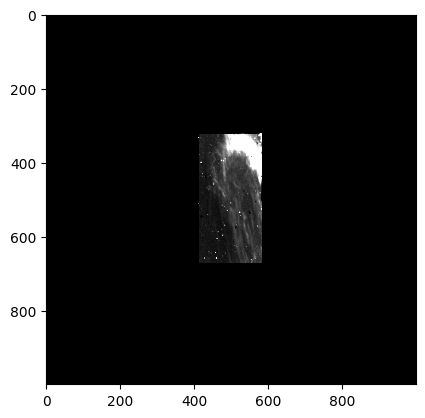

In [45]:
iris_im = iris_im.numpy()
iris_im = np.squeeze(iris_im[0])
plt.imshow(iris_im, cmap='gray', vmin=0, vmax=50)



In [ ]:
def create_loaders(test_percent=0.8, batch_size=64):

    # Randomly split the data into train and validation sets based on observation
    assert set(os.listdir("../data/sdo/")) == set(os.listdir("../data/iris/")), 'obs not in both directories' # Make sure the same obs are in both directories
    obs_list = os.listdir("../data/sdo/") # Get the list of obs
    train_set, test_set = train_test_split(obs_list, test_size=test_percent, random_state=42) # Split the array into train and test sets
    train_obs_list = train_set
    test_obs_list = test_set

    train_dataset = AIAIRISDataset(sdo_channels=['304'], iris_channel='1400', obs_list=train_obs_list)
    test_dataset = AIAIRISDataset(sdo_channels=['304'], iris_channel='1400', obs_list=test_obs_list)

    # Create data loaders for each dataset
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

class AIAIRISDataset(Dataset):
    def __init__(self, sdo_channels=['304'], iris_channel='1400', obs_list=None):
        super(AIAIRISDataset, self).__init__()

        # Collect all possible paths for iris into a single list
        iris_paths = []
        for obs in obs_list:
            path_to_iris_obs = f'../data/iris/{obs}/{iris_channel}/'
            for file in os.listdir(path_to_iris_obs):
                iris_paths.append(f'{path_to_iris_obs}/{file}')

        # Collect all possible paths for sdo into a single list (note that we can sample a few channles, will help as a form of data augmentation)
        sdo_paths = []
        for obs in obs_list:
            path_to_sdo_obs = f'../data/sdo/{obs}/'
            for sdo_channel in sdo_channels:
                path_to_sdo_obs_channel = f'{path_to_sdo_obs}/{sdo_channel}/'
                for file in os.listdir(path_to_sdo_obs_channel):
                    sdo_paths.append(f'{path_to_sdo_obs_channel}/{file}')

        # Randomly shuffle the indices
        iris_rand_ints = np.random.choice(len(iris_paths), size=len(iris_paths), replace=False)
        sdo_rand_ints = np.random.choice(len(sdo_paths), size=len(sdo_paths), replace=False)
        self.iris_paths = np.array(iris_paths)[iris_rand_ints]
        self.sdo_paths = np.array(sdo_paths)[sdo_rand_ints]

    # def transform(self, sample):
    #     # Define the transformations you want to apply
    #     transform = transforms.Compose([
    #     transforms.RandomHorizontalFlip(),
    #     transforms.RandomVerticalFlip(),
    #     transforms.ToTensor(),
    #     ]) 
    #     # Apply the transformations to the sample
    #     augmented_sample = transform(sample)
    
    #     return augmented_sample

    def __len__(self):
        return min(len(self.iris_paths), len(self.sdo_paths))
                                            
    def __getitem__(self, idx):

        # Load the images
        iris_im = np.load(self.iris_paths[idx])
        sdo_im = np.load(self.sdo_paths[idx])

        # # Apply augmentation
        # augmented_iris_im = transform(iris_im)
        # augmented_sdo_im = transform(sdo_im)

        return iris_im, sdo_im
    
# if __name__ == '__main__':
#     train_loader, test_loader = create_loaders()
#     for i, (iris_im, sdo_im) in enumerate(train_loader):
#         print(i, iris_im.shape, sdo_im.shape)
#         if i == 10: break

In [ ]:
# Define your dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        # Implement your data loading logic here
        sample = self.data[index]
        # Return the augmented sample
        return self.transform(sample)

    def __len__(self):
        return len(self.data)

    def transform(self, sample):
        # Define the transformations you want to apply
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
        ])
        # Apply the transformations to the sample
        augmented_sample = transform(sample)
        return augmented_sample

# Create your dataset instance
dataset = CustomDataset(data)

# Create the data loader with your dataset
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
# Collect all possible paths for sdo into a single list (note that we can sample a few channles, will help as a form of data augmentation)
sdo_paths = []
for obs in test_obs_list:
    path_to_sdo_obs = f'../data/sdo/{obs}/'
    for sdo_channel in sdo_channels:
        path_to_sdo_obs_channel = f'{path_to_sdo_obs}/{sdo_channel}/'
        for file in os.listdir(path_to_sdo_obs_channel):
            sdo_paths.append(f'{path_to_sdo_obs_channel}/{file}')

# Randomly shuffle the paths. Note that results could be improved here by alligning images in time instead of shuffle. We shuffle here because cadance already means they are not alligned
iris_rand_ints =  torch.randint(0, len(iris_paths), (len(iris_paths),)) # Randomly shuffle the indices
sdo_rand_ints = torch.randint(0, len(sdo_paths), (len(sdo_paths),)) # Randomly shuffle the indices
iris_paths = [iris_paths[i] for i in iris_rand_ints]
sdo_paths = [sdo_paths[i] for i in sdo_rand_ints]


def __len__():
    return min(len(self.iris_paths), len(self.sdo_paths
                                         
def __getitem__(self, idx):

    # Load the images
    iris_im = np.load(self.iris_paths[idx])
    sdo_im = np.load(self.sdo_paths[idx])

    return torch.Tensor(self.iris_paths[inx]), torch.Tensor(self.sdo_paths[inx])


In [15]:
class AIAIRISDataset(Dataset):
    def __init__(self, test_percent=0.8, sdo_channels=['304'], iris_channel='1400', transform=None):
        super(AIAIRISDataset, self).__init__()

        #! This should be outside of the class 
        # Randomly split the data into train and validation sets based on observation
        assert set(os.listdir("../data/sdo/")) == set(os.listdir("../data/iris/")), 'obs not in both directories' # Make sure the same obs are in both directories
        obs_list = os.listdir("../data/sdo/") # Get the list of obs
        train_set, test_set = train_test_split(obs_list, test_size=test_percent, random_state=42) # Split the array into train and test sets
        train_obs_list = train_set
        test_obs_list = test_set

        # Collect all possible paths for iris into a single list
        iris_paths = []
        for obs in test_obs_list:
            path_to_iris_obs = f'../data/iris/{obs}/'
            for file in os.listdir(path_to_iris_obs):
                iris_paths.append(f'{path_to_iris_obs}/{file}')

        # Collect all possible paths for sdo into a single list
        sdo_paths = []
        for obs in test_obs_list:
            path_to_sdo_obs = f'../data/sdo/{obs}/'
            for sdo_channel in sdo_channels:
                path_to_sdo_obs_channel = f'{path_to_sdo_obs}/{sdo_channel}/'
                for file in os.listdir(path_to_sdo_obs_channel):
                    sdo_paths.append(f'{path_to_sdo_obs_channel}/{file}')


        # Randomly shuffle the paths
        iris_rand_ints =  torch.randint(0, len(iris_paths), (len(iris_paths),)) # Randomly shuffle the indices
        sdo_rand_ints = torch.randint(0, len(sdo_paths), (len(sdo_paths),)) # Randomly shuffle the indices




        
        
        
            
            # Get the max number of images compared aia and iris channels (aia has much higher cadance)
            n_sdo_ims = len(os.listdir(obs_channel_path_sdo))
            n_iris_ims = len(os.listdir(obs_channel_path_iris))
            n_paired = max(n_sdo_ims, n_iris_ims)



            iris_rand_ints =  torch.randint(0, n_iris_ims, (n_paired,)) # Randomly shuffle the indices   
            sdo_rand_ints = torch.randint(0, n_sdo_ims, (n_paired,)) # Randomly shuffle the indices

            sdo_ims = torch.Tensor([np.load(f'{obs_channel_path_sdo}/{i}.npy') for i in sdo_rand_ints]) # Load the images
            iris_ims = torch.Tensor([np.load(f'{obs_channel_path_iris}/{i}.npy') for i in iris_rand_ints]) # Load the images
    
            



        root_path = f'../data/{sdo_channel}'

None


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, folder1_path, folder2_path, transform=None):
        self.folder1_path = folder1_path
        self.folder2_path = folder2_path
        self.transform = transform
        
        self.folder1_files = os.listdir(folder1_path)
        self.folder2_files = os.listdir(folder2_path)
        
    def __len__(self):
        return min(len(self.folder1_files), len(self.folder2_files))
    
    def __getitem__(self, idx):
        folder1_image = np.load(os.path.join(self.folder1_path, self.folder1_files[idx]))
        folder2_image = np.load(os.path.join(self.folder2_path, self.folder2_files[idx]))
        
        folder1_image = Image.fromarray(folder1_image)
        folder2_image = Image.fromarray(folder2_image)
        
        if self.transform is not None:
            folder1_image = self.transform(folder1_image)
            folder2_image = self.transform(folder2_image)
        
        return folder1_image, folder2_image

In [ ]:
def create_loaders(sdo_channel='304', iris_channel='1400', test_percent=0.2, batchsize=64):
          
          # Randomly split the data into train and validation sets based on observation
          assert set(os.listdir("../data/sdo/")) == set(os.listdir("../data/iris/")), 'obs not in both directories' # Make sure the same obs are in both directories
          obs_list = os.listdir("../data/sdo/") # Get the list of obs
          train_set, test_set = train_test_split(obs_list, test_size=test_percent, random_state=42) # Split the array into train and test sets
 
          # Get the max number of images compared aia and iris channels (aia has much higher cadance)
          sdo_list = os.listdir(obs_channel_path_sdo)
          iris_list = os.listdir(obs_channel_path_iris)
          n_sdo_ims = len(sdo_list)
          n_iris_ims = len(_list)
          n_paired = max(n_sdo_ims, n_iris_ims) 

In [3]:
root_dir = '../data/'
obs_split = AIAIRISDataset()
print(obs_split.test_list)
print(obs_split.train_list)
print(len(obs_split.test_list))
print(len(obs_split.train_list))

NameError: name 'AIAIRISDataset' is not defined

In [57]:
import os 
obs = '20131119_171530_3893012103'
sdo_channel = '335'
obs_channel_path_sdo = f'../data/sdo/{obs}/{sdo_channel}'
aia_im_paths = os.listdir(obs_channel_path_sdo)
aia_im_paths

['20131119_171530_3893012103_335_96.npy',
 '20131119_171530_3893012103_335_82.npy',
 '20131119_171530_3893012103_335_69.npy',
 '20131119_171530_3893012103_335_55.npy',
 '20131119_171530_3893012103_335_41.npy',
 '20131119_171530_3893012103_335_129.npy',
 '20131119_171530_3893012103_335_101.npy',
 '20131119_171530_3893012103_335_115.npy',
 '20131119_171530_3893012103_335_277.npy',
 '20131119_171530_3893012103_335_263.npy',
 '20131119_171530_3893012103_335_288.npy',
 '20131119_171530_3893012103_335_289.npy',
 '20131119_171530_3893012103_335_262.npy',
 '20131119_171530_3893012103_335_276.npy',
 '20131119_171530_3893012103_335_114.npy',
 '20131119_171530_3893012103_335_100.npy',
 '20131119_171530_3893012103_335_128.npy',
 '20131119_171530_3893012103_335_40.npy',
 '20131119_171530_3893012103_335_54.npy',
 '20131119_171530_3893012103_335_68.npy',
 '20131119_171530_3893012103_335_83.npy',
 '20131119_171530_3893012103_335_97.npy',
 '20131119_171530_3893012103_335_81.npy',
 '20131119_171530_3893

In [53]:
torch.randperm(5) 
torch.randint(0, 5, (3,))

tensor([1, 2, 3])

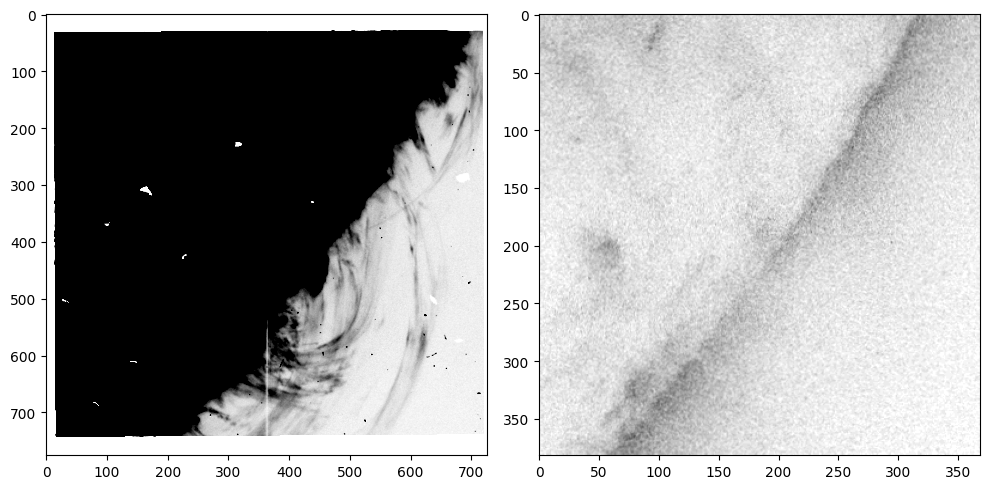

In [47]:
import numpy as np
import matplotlib.pyplot as plt
iris_im = np.load('/Users/brandonlpanos/gits/cyclegan/data/iris/20131119_171530_3893012103/1400/20131119_171530_3893012103_1400_0.npy')
sdo_im = np.load('/Users/brandonlpanos/gits/cyclegan/data/sdo/20131119_171530_3893012103/335/20131119_171530_3893012103_335_0.npy')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(iris_im, aspect='auto', vmax=50, vmin=0, cmap='binary')
ax2.imshow(sdo_im, aspect='auto', vmax=25, vmin=0, cmap='binary')
plt.tight_layout()
plt.show()
plt.close(fig)



In [58]:
a = ['2', '3', '5', '6']
b = ['2', '3', '5', '6', '3', '5', '6']
b = b[0:len(a)]
b

['2', '3', '5', '6']

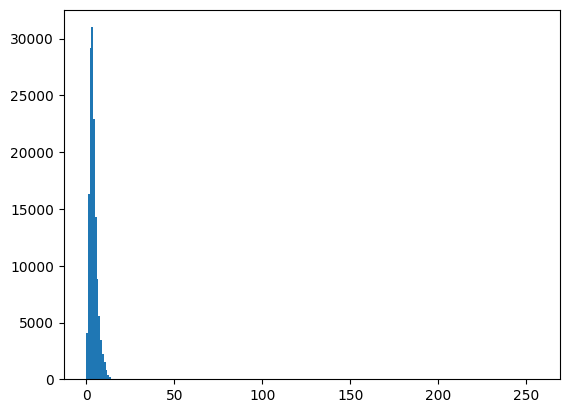

In [44]:
plt.hist(sdo_im.ravel(), bins=256, range=[0, 256]);

In [16]:
print(set(os.listdir(f"{root_dir}/sdo/")))

{'20160125_154326_3690091404', '20140702_232900_3824611254', '20161210_195716_3620110404', '20160310_025433_3690133104', '20180830_135414_3620110404', '20160212_122145_3690113103', '20131119_171530_3893012103', '20131206_023345_3800260154', '20160212_104419_3690113103', '20140327_014149_3860513253', '20160212_135911_3690113103', '20131211_075749_3813513603', '20131208_230830_3880262154', '20140211_111136_3880013204', '20220923_103842_3690133103', '20200210_000010_3600262403', '20170204_011329_3690015104', '20140701_111316_3824611254', '20160915_192231_3630111104'}


In [17]:
print(set(os.listdir(f"{root_dir}/iris/")))

{'20160125_154326_3690091404', '20140702_232900_3824611254', '20161210_195716_3620110404', '20160310_025433_3690133104', '20180830_135414_3620110404', '20160212_122145_3690113103', '20131119_171530_3893012103', '20131206_023345_3800260154', '20160212_104419_3690113103', '20140327_014149_3860513253', '20160212_135911_3690113103', '20131211_075749_3813513603', '20131208_230830_3880262154', '20140211_111136_3880013204', '20220923_103842_3690133103', '20200210_000010_3600262403', '20170204_011329_3690015104', '20140701_111316_3824611254', '20160915_192231_3630111104'}


In [1]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import rcParams
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from skimage import exposure, filters, util

In [2]:
from dataset import create_loaders
train_loader, test_loader, train_iris_paths, train_sdo_paths, test_iris_paths, test_sdo_paths  = create_loaders(test_percent=0.8, batch_size=64)
iris_ims, sdo_ims = next(iter(train_loader))
iris_ims = np.squeeze(iris_ims)
sdo_ims = np.squeeze(sdo_ims)

print(sdo_ims.shape, sdo_ims.shape)

# iris_im = iris_ims[0]
# plt.imshow(iris_im, cmap='gray', vmin=0, vmax=50)

torch.Size([64, 463, 463]) torch.Size([64, 463, 463])


In [11]:
def quick_look_gen(images, clr='k', dim=16, savename=None):

    rcParams['font.family'] = 'serif'
    rcParams['font.size'] = 17
    fig = plt.figure(figsize=(12,12))
    gs = fig.add_gridspec(dim, dim, wspace=0, hspace=-0.5)
    for i in range(dim):
        for j in range(dim):
            ind = (i*dim)+j
            ax = fig.add_subplot(gs[i, j])
            im = images[ind].numpy()

            # push into dynamic range and other
            im = exposure.equalize_hist(im)
            im = exposure.rescale_intensity(im)
            p2, p98 = np.percentile(im, (2, 98))
            im = exposure.rescale_intensity(im, in_range=(p2, p98))

            # Get rid of sharp boarders
            mean_value = np.mean(im)
            # Find the indices of the smallest values
            indices = np.where(im == np.min(im))
            # Replace the smallest values with the mean value
            im[indices] = mean_value

            ax.imshow(im, cmap='binary', alpha=0.8)
            # plt.text(0.02,0.9,dtypes[ind],fontsize=12,c='white',
            #          horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
            plt.xticks([])
            plt.yticks([])
            ax.spines['bottom'].set_color('black')
            ax.spines['top'].set_color('black')
            ax.spines['right'].set_color('black')
            ax.spines['left'].set_color('black')
    if savename is not None:
        plt.savefig(f'../assets/{savename}.pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)   
    return None

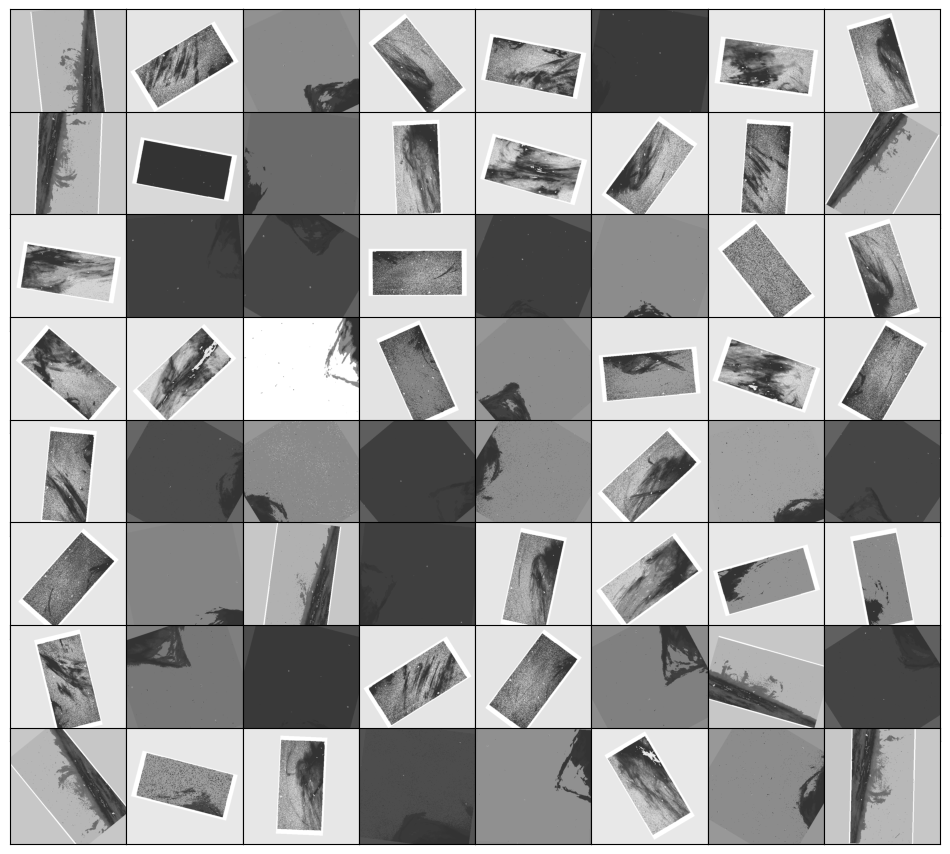

In [12]:
quick_look_gen(iris_ims, dim=8, savename='iris_train_ims')

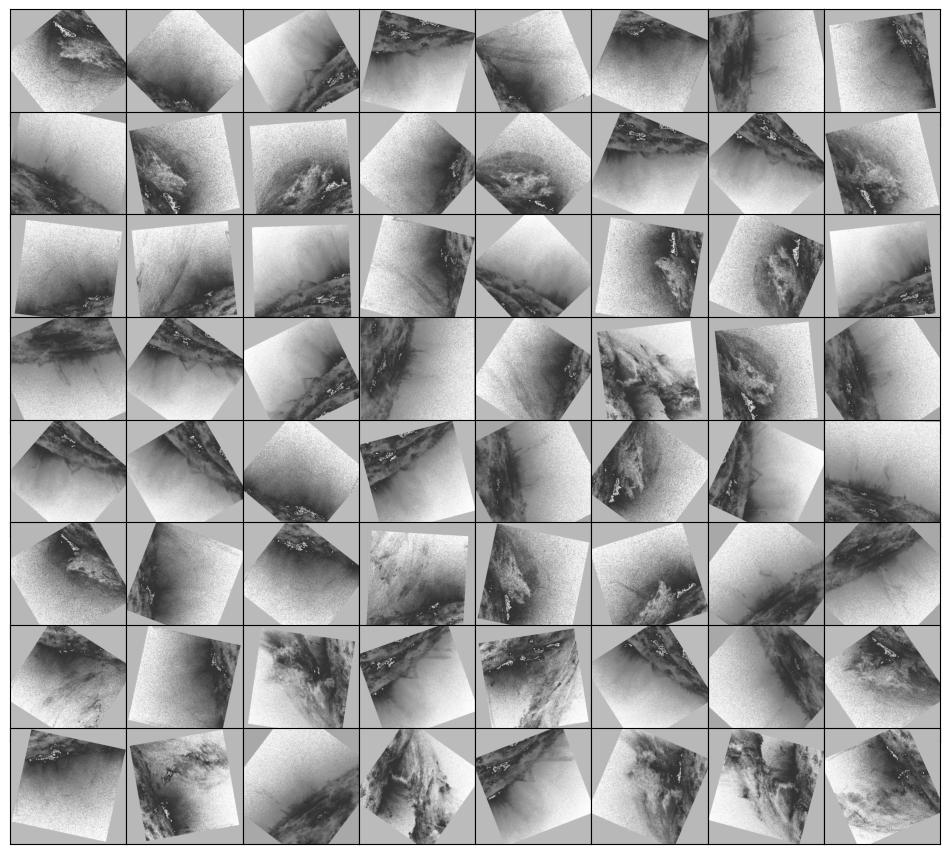

In [13]:
quick_look_gen(sdo_ims, dim=8, savename='sdo_train_ims')

In [ ]:
x_dims = []
y_dims = []
for path in train_iris_paths:
    try:data = np.load(path)
    except: continue
    x_dims.append(data.shape[0])
    y_dims.append(data.shape[1])
for path in train_sdo_paths:
    try:data = np.load(path)
    except: continue
    x_dims.append(data.shape[0])
    y_dims.append(data.shape[1])
for path in test_iris_paths:
    try:data = np.load(path)
    except: continue
    x_dims.append(data.shape[0])
    y_dims.append(data.shape[1])
for path in test_sdo_paths:
    try:data = np.load(path)
    except: continue
    x_dims.append(data.shape[0])
    y_dims.append(data.shape[1])
# FInd max dims
max(x_dims), max(y_dims)

In [11]:
x_dims = []
y_dims = []
for path in train_iris_paths:
    try:data = np.load(path)
    except: continue
    x_dims.append(data.shape[0])
    y_dims.append(data.shape[1])
for path in train_sdo_paths:
    try:data = np.load(path)
    except: continue
    x_dims.append(data.shape[0])
    y_dims.append(data.shape[1])
for path in test_iris_paths:
    try:data = np.load(path)
    except: continue
    x_dims.append(data.shape[0])
    y_dims.append(data.shape[1])
for path in test_sdo_paths:
    try:data = np.load(path)
    except: continue
    x_dims.append(data.shape[0])
    y_dims.append(data.shape[1])
# FInd mean dims
int(np.mean(x_dims)), int(np.mean(y_dims))

(463, 441)